In [4]:

import torch


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import nnfs
import pickle
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_openml



nnfs.init()

LOADING AND STANDARDIZING THE DATA FOR NEURAL NETWORK


In [6]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False,parser='auto')


X, y = mnist.data, mnist.target.astype(np.int8)  # Convert labels to int

X = X.reshape(X.shape[0], -1) 
X = X / 255.0  


scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=40)

DEFINING THE LAYERS AND ACTIVATION CLASSES AND FORWARD-BACKWARD METHODS

In [11]:
class Layer:
    def __init__(self, n_inputs, n_neurons):
        self.weights = 0.1 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))

    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases

    def backward(self, dvalues):
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        self.dinputs = np.dot(dvalues, self.weights.T)




class Activation_ReLU:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)

    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0  




class Activation_sigmoid:
    def forward(self,inputs):
        self.inputs=inputs
        self.output=np.array(1/(1+np.exp(-inputs)))
    
    def backward(self):
        self.dinputs=self.output*(1-self.output)




class Activation_Softmax:
    def forward(self, inputs):
        exp_inputs = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        self.output = exp_inputs / np.sum(exp_inputs, axis=1, keepdims=True)

    def backward(self, dvalues, y_true): 
        samples = len(dvalues)
        self.dinputs = dvalues.copy()

        if y_true.ndim == 1:
            self.dinputs[range(samples), y_true] -= 1
        else:
            self.dinputs -= y_true

        self.dinputs /= samples





class Loss_CategoricalCrossentropy:
    def forward(self, y_pred, y_true):
        clipped_y_pred = np.clip(y_pred, 1e-8, 1 - 1e-8)
        if len(y_true.shape) == 1:
            correct_confidences = clipped_y_pred[range(len(y_pred)), y_true]
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(clipped_y_pred * y_true, axis=1)
        return np.mean(-np.log(correct_confidences))





class Optimizer_SGD:
    def __init__(self, learning_rate=0.01):
        self.learning_rate = learning_rate

    def update_params(self, layer):
        layer.weights -= self.learning_rate * layer.dweights
        layer.biases -= self.learning_rate * layer.dbiases


NEURAL NETWORK INITIALIZATION


In [ ]:
layer_sizes = [784, 256, 64, 10]
layers = [Layer(layer_sizes[i], layer_sizes[i+1]) for i in range(len(layer_sizes)-1)]
activation_hidden_layers = [Activation_ReLU() for _ in range(len(layers)-1)]
activation_softmax = Activation_Softmax()
loss_function = Loss_CategoricalCrossentropy()
optimizer = Optimizer_SGD(learning_rate=0.01)
epochs = 21
loss_history = []
predictions=[]

TRAINING NEURAL NETWORK

In [102]:
batch_size=16



for epoch in range(epochs):
    for i in range(0, X_train.shape[0], batch_size):
        X_batch = X_train[i:i + batch_size]
        y_batch = y_train[i:i + batch_size]
        current_input = X_batch
        for j, layer in enumerate(layers[:-1]):
            layer.forward(current_input)
            activation_hidden_layers[j].forward(layer.output)
            current_input = activation_hidden_layers[j].output
        
        layers[-1].forward(current_input)
        activation_softmax.forward(layers[-1].output)
        
        loss = loss_function.forward(activation_softmax.output, y_batch)
        loss_history.append(loss)
        
        activation_softmax.backward(activation_softmax.output, y_batch)
        layers[-1].backward(activation_softmax.dinputs)
        
        for j in reversed(range(len(layers)-1)):
            activation_hidden_layers[j].backward(layers[j+1].dinputs)
            layers[j].backward(activation_hidden_layers[j].dinputs)
        
        for layer in layers:
            optimizer.update_params(layer)
        
    if epoch % 2 == 0:
            print(f'Epoch: {epoch}, Loss: {loss:.8f}')

print(f"\nFinal Loss over training data= {(loss_history[-1])}")


Epoch: 0, Loss: 0.31778654
Epoch: 2, Loss: 0.10320938
Epoch: 4, Loss: 0.04088651
Epoch: 6, Loss: 0.02491561
Epoch: 8, Loss: 0.01206531
Epoch: 10, Loss: 0.00644392
Epoch: 12, Loss: 0.00332249
Epoch: 14, Loss: 0.00184558
Epoch: 16, Loss: 0.00130697
Epoch: 18, Loss: 0.00093130
Epoch: 20, Loss: 0.00088971

Final Loss over training data= 0.0008897054940462112


SAVING THE WEIGHTS AND BIASES IN SEPERATE BINARY FILE

In [103]:

model_params={
    "weights" : [layer.weights for layer in layers],
    "biases": [layer.biases for layer in layers]
}


with open ("model_params_stored_mnist.pk1","wb") as f:
    pickle.dump(model_params,f)

print("Model Parameters saved successfully.")
# print(model_params)


Model Parameters saved successfully.


TESTING AND LOADING NEURAL NETWORK FOR TESTING MODEL

In [8]:
def load_model(hidden_layers,input_size,output_size,filename):
    layer_size=[input_size]+hidden_layers+[output_size]
    Layers=[Layer(layer_size[i], layer_size[i+1]) for i in range(len(layer_size)-1)]

    with open(filename,"rb") as f:
        params=pickle.load(f)
    
    for i,layer in enumerate(Layers):
        layer.weights=params["weights"][i]
        layer.biases=params["biases"][i]
    
    
    
    return Layers

In [2]:
def testing(X_new,Y_new,model_params_stored_filename,hidden_layers,output_size):
   
    correct=0
    input_size=X_new.shape[1]
    Layers=load_model(hidden_layers,input_size,output_size,model_params_stored_filename)


    # scaler = StandardScaler()
    # X_new = scaler.fit_transform(X_new)

    current_input = X_new
    activation1 = Activation_ReLU()
    activation2 = Activation_Softmax()

    for i, layer in enumerate(Layers[:-1]):
        layer.forward(current_input)
        activation1.forward(layer.output)
        current_input = activation1.output

    Layers[-1].forward(current_input)
    activation2.forward(Layers[-1].output)


    predictions = np.argmax(activation2.output, axis=1)

    for i in range(len(Y_new)):
        if Y_new[i]==predictions[i]:
            correct+=1
    
    
    acc=correct/len(Y_new) *100
    
    print("Predictions:  ", predictions)
    print("Actual Labels:", Y_new)
    print(f"\nAccuracy over testing data= {acc:.2f}%")

    return predictions

RUNNING THE TEST AND RESULTS

In [106]:
print(len(y_test))

14000


In [12]:

predictions=testing(X_test,y_test,"model_params_stored_mnist.pk1",[256,64],10)

Predictions:   [4 1 2 ... 7 3 0]
Actual Labels: [4 1 2 ... 7 3 0]

Accuracy over testing data= 96.49%


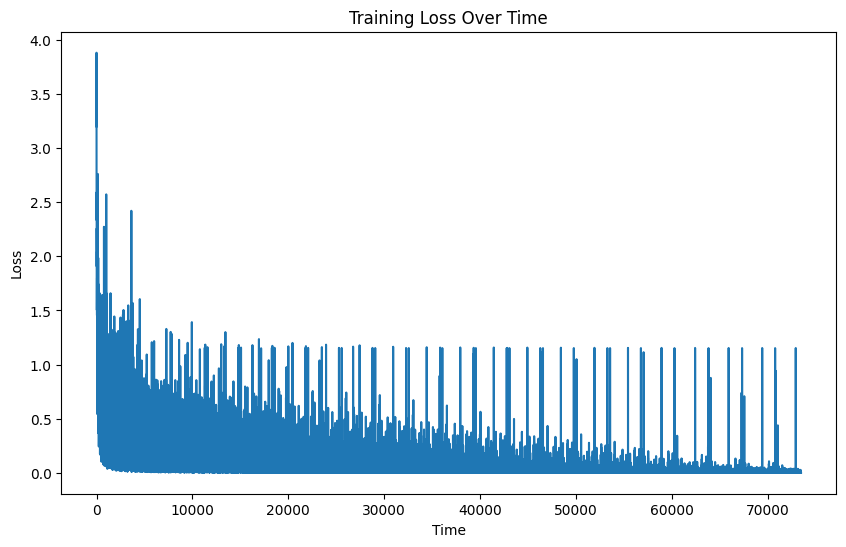

In [108]:
plt.figure(figsize=(10, 6))
plt.plot(loss_history)
plt.title('Training Loss Over Time')
plt.xlabel('Time')
plt.ylabel('Loss')
plt.show()



In [109]:
def plot_spiral_predictions(X, y_true, y_pred):
    """
    Plots two side-by-side spirals:
    - Left: True labels (Red, Green, Blue)
    - Right: Predicted labels (model's classification)
    
    Parameters:
    - X: Data points (Nx2)
    - y_true: True class labels
    - y_pred: Predicted class labels
    """

    # Define colors for three classes
    colors = ['red', 'green', 'blue']

    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot True Labels
    axes[0].scatter(X[:, 0], X[:, 1], c=[colors[label] for label in y_true], edgecolors='k', alpha=0.7)
    axes[0].set_title("True Spiral Classes")
    axes[0].set_xlabel("X")
    axes[0].set_ylabel("Y")

    # Plot Predicted Labels
    axes[1].scatter(X[:, 0], X[:, 1], c=[colors[label] for label in y_pred], edgecolors='k', alpha=0.7)
    axes[1].set_title("Predicted Spiral Classes")
    axes[1].set_xlabel("X")
    axes[1].set_ylabel("Y")

    # Display the plots
    plt.tight_layout()
    plt.show()

In [110]:
def plot_iris_predictions(testing_function, model_filename, hidden_layers, output_size):
    
    iris = load_iris()
    X, y = iris.data, iris.target  

   
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

   
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

   
    predictions = testing_function(X_test, y_test, model_filename, hidden_layers, output_size)

  
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

   
    X_pca_train, X_pca_test = train_test_split(X_pca, test_size=0.2, random_state=42)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

   
    axes[0].scatter(X_pca_test[:, 0], X_pca_test[:, 1], c=y_test, cmap="coolwarm", edgecolors="k")
    axes[0].set_title("True Classes")
    axes[0].set_xlabel("PCA Component 1")
    axes[0].set_ylabel("PCA Component 2")

    
    axes[1].scatter(X_pca_test[:, 0], X_pca_test[:, 1], c=predictions, cmap="coolwarm", edgecolors="k", marker="s")
    axes[1].set_title("Predicted Classes")
    axes[1].set_xlabel("PCA Component 1")
    axes[1].set_ylabel("PCA Component 2")

    plt.tight_layout()
    plt.show()

In [111]:
def visualize_misclassified_images(X_test, y_test, predictions):
    misclassified_indexes = np.where(predictions != y_test)[0]  # Find misclassified indices

    if len(misclassified_indexes) == 0:
        print("No misclassified images found!")
        return

    num_misclassified=len(misclassified_indexes)
    print(f"Total Misclassified Images: {num_misclassified}")

    images_per_row = 4  # Fixed to 4 images per row
    num_rows = num_misclassified // images_per_row  # Only complete rows
    if num_misclassified % images_per_row != 0:
        num_rows += 1  # Add extra row if needed
    

    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(15, num_rows * 4))

    for idx, misclassified_idx in enumerate(misclassified_indexes):
        row = idx // images_per_row  # Fixed row placement
        col = idx % images_per_row   # Fixed column placement
        ax = axes[row, col] if num_rows > 1 else axes[col]  # Handle single row case

        ax.imshow(X_test[misclassified_idx].reshape(28, 28), cmap="gray")
        ax.set_title(f"True: {y_test[misclassified_idx]}, Pred: {predictions[misclassified_idx]}", fontsize=12)
        ax.axis("off")

    # Hide any empty subplots if total images < grid space
    for i in range(num_misclassified, num_rows * images_per_row):
        fig.delaxes(axes.flatten()[i])

    plt.show()


In [112]:
mismatch_count=[0 for _ in range(len(np.unique(y_test)))]


for true,pred in zip(y_test,predictions):
    if true!=pred:
        mismatch_count[true]+=1


for i in range (len(mismatch_count)):
    print(f"Number of mismatched images for image with {i}= {mismatch_count[i]}")



Number of mismatched images for image with 0= 25
Number of mismatched images for image with 1= 29
Number of mismatched images for image with 2= 61
Number of mismatched images for image with 3= 66
Number of mismatched images for image with 4= 33
Number of mismatched images for image with 5= 58
Number of mismatched images for image with 6= 39
Number of mismatched images for image with 7= 43
Number of mismatched images for image with 8= 70
Number of mismatched images for image with 9= 67


Total Misclassified Images: 491


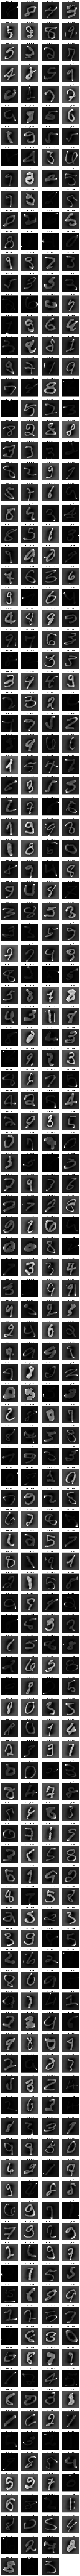

In [113]:
visualize_misclassified_images(X_test, y_test, predictions)